### 予測モデルの仕組みをわかりやすく説明します！

#### どんなことを予測するの？
このモデルは、**「当月末の限界利益がどのくらいになりそうか」**を、日次のデータを使って予測するものです。

#### どうやって予測するの？

1.  **日次のデータを使うよ！**
    *   毎日の限界利益データ（「MP」という名前だよ）と、確定値、A、B、C、Dの値を使います。
    *   これらのデータから、「当月末にどれくらいの限界利益があるか」のヒントを探すんだ。

2.  **２つの限界利益を足し算するよ！**
    当月末の限界利益を予測するとき、大きく分けて２つの部分に分けて考えます。

    *   **「もう決まっている限界利益（Confirmed）」**:
        これは、「確定MP」と「AMP（A）」を合わせた限界利益です。これはほぼ確実に手に入る限界利益だね！

    *   **「これから増えそうな限界利益（Additional）」**:
        これは、「まだ確定していないけど、これまでの経験から考えると、これくらいは増えそうだね」という限界利益です。
        この部分を予測するために、特別な計算を使います。特に「BCD」という種類の限界利益（「B」「C」「D」という３つの種類の限界利益を足したものだよ）が、どのくらい「これから増えそうな限界利益」に変わるかを過去のデータから学ぶんだ。

3.  **合計するよ！**
    最後に、「もう決まっている限界利益」と「これから増えそうな限界利益」を足し合わせると、当月末の限界利益の予測が出てきます。

#### まとめると...

このモデルは、日次の限界利益データ（確定値、A、B、C、D）を使って、**「すでに決まっている限界利益」**と**「過去の傾向から見て、これから増えそうな限界利益」**を別々に計算し、それらを合計することで、**「当月末の限界利益がどのくらいになりそうか」**を教えてくれる賢い予測屋さんなんです！

### 予測モデルの仕組みをもう少し詳しく説明します！

先ほどは、当月末の限界利益を「もう決まっている限界利益」と「これから増えそうな限界利益」の2つに分けて考えると説明しましたね。

「これから増えそうな限界利益（Additional）」を予測するために、このモデルでは主に2つの方法を使っています。

#### 1. 「ランダムフォレスト」という賢い予測屋さん

*   **ランダムフォレストって何？**
    これは、たくさんの小さな「予測の木」を集めて、みんなで相談して答えを出すようなものです。例えば、「この状況なら限界利益がこれくらい増えるんじゃない？」という予測を、それぞれが考えて、最後に一番良い答えを決めるイメージです。

*   **どうやって使うの？**
    過去のデータ（特に「B」「C」「D」といった種類の限界利益や、それが何月の何日目に起こったか）をこのたくさんの「予測の木」たちに教えてあげます。すると、「B」がいくらで「C」がいくらで「D」がいくらで、何月の何日目だったら、どれくらい「これから増えそうな限界利益」になるかを賢く予測してくれるんです。

#### 2. 「月別・日別の転換率」で予測

*   **転換率って何？**
    これは、「これくらいの限界利益（BCD）があったら、過去の経験から見て、だいたい何パーセントくらいが当月末に実際に限界利益になるだろう？」という割合のことです。

*   **どうやって使うの？**
    例えば、「1月の15日だったら、BCDの限界利益があったら過去のデータではだいたい70%が『これから増えそうな限界利益』になっていたな」というように、月ごと・日ごとにその割合（転換率）を計算しておきます。
    そして、新しい予測をするときには、その月とその日の転換率を使って「これくらいは増えるだろう」と予測します。

#### 最終的な予測

このモデルでは、この「ランダムフォレスト」の予測と「月別・日別の転換率」を使った予測を、良いバランスで組み合わせています。こうすることで、片方だけの予測よりも、もっと正確な「これから増えそうな限界利益」を出すことができるんですよ。

これに「もう決まっている限界利益」を足し合わせることで、当月末の限界利益を最終的に予測しています。

# MP Current Month-End Prediction Model
## 日次データから当月末MP予測モデル

## 1. ライブラリのインポート

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


## 2. データの読み込み

In [18]:
try:
    from google.colab import files
    print('Upload CSV file:')
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except:
    filename = 'progress_data.csv'
    print(f'Using: {filename}')

Upload CSV file:


Saving 進捗データ_当月次月_2026020317540815025.csv to 進捗データ_当月次月_2026020317540815025.csv


In [19]:
try:
    df = pd.read_csv(filename, encoding='utf-8-sig')
except:
    df = pd.read_csv(filename, encoding='shift_jis')

print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Shape: (2141, 12)
Columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']


,行ラベル,合計 / MP,合計 / 確定MP,合計 / AMP,合計 / BMP,合計 / CMP,合計 / DMP,合計 / 次月確定MP,合計 / 次月AMP,合計 / 次月BMP,合計 / 次月CMP,合計 / 次月DMP
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,0,15815626,1787889,2610055,58101088
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,0,16514617,2656829,3009163,54178242
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,0,16344677,3487701,3368643,50733450
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,0,16344677,3487701,3368643,50733450
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,0,16523619,3487701,4072319,50733450


## 3. データ前処理（日次データを使用）

In [20]:
# 元のカラム名を保存
original_columns = df.columns.tolist()
print(f'Original columns: {original_columns}')

# 日付処理
df['date'] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
# NaT（無効な日付）を含む行を削除
df = df.dropna(subset=['date']).copy()

# 年月情報を追加
df['year_month'] = df['date'].dt.to_period('M')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print(f'\nDaily data points: {len(df)}')

Original columns: ['行ラベル', '合計 / MP', '合計 / 確定MP', '合計 / AMP', '合計 / BMP', '合計 / CMP', '合計 / DMP', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP']

Daily data points: 2141


In [21]:
# カラム名を変更（確定、A、B、C、Dに対応）
col_mapping = {
    original_columns[1]: 'MP',
    original_columns[2]: 'Kakutei',  # 確定MP
    original_columns[3]: 'A',        # AMP
    original_columns[4]: 'B',        # BMP
    original_columns[5]: 'C',        # CMP
    original_columns[6]: 'D'         # DMP
}
print(f'Mapping: {col_mapping}')

df = df.rename(columns=col_mapping)

# 数値変換
for col in ['MP', 'Kakutei', 'A', 'B', 'C', 'D']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f'\nColumns after mapping: {df.columns.tolist()}')
df.head()

Mapping: {'合計 / MP': 'MP', '合計 / 確定MP': 'Kakutei', '合計 / AMP': 'A', '合計 / BMP': 'B', '合計 / CMP': 'C', '合計 / DMP': 'D'}

Columns after mapping: ['行ラベル', 'MP', 'Kakutei', 'A', 'B', 'C', 'D', '合計 / 次月確定MP', '合計 / 次月AMP', '合計 / 次月BMP', '合計 / 次月CMP', '合計 / 次月DMP', 'date', 'year_month', 'month', 'day']


,行ラベル,MP,Kakutei,A,B,C,D,合計 / 次月確定MP,合計 / 次月AMP,合計 / 次月BMP,合計 / 次月CMP,合計 / 次月DMP,date,year_month,month,day
0,2020/04/01,52612321,3560426,49051895,9945801,6513693,24336375,0,15815626,1787889,2610055,58101088,2020-04-01,2020-04,4,1
1,2020/04/02,56827598,3851781,52975817,7023531,5452199,22024972,0,16514617,2656829,3009163,54178242,2020-04-02,2020-04,4,2
2,2020/04/03,58726803,5588962,53137841,5750444,5316388,19336368,0,16344677,3487701,3368643,50733450,2020-04-03,2020-04,4,3
3,2020/04/04,58726803,5588962,53137841,5750444,5316388,19336368,0,16344677,3487701,3368643,50733450,2020-04-04,2020-04,4,4
4,2020/04/05,59218260,5742347,53475913,5744476,5316685,19336368,0,16523619,3487701,4072319,50733450,2020-04-05,2020-04,4,5


In [22]:
# 各月の月末MPを取得（ターゲット変数として使用）
month_end_mp = df.groupby('year_month')['MP'].last().to_dict()

# 日次データに当月末MPを追加
df['Current_Month_End_MP'] = df['year_month'].map(month_end_mp)

# 訓練データ作成（月末以外の日のデータを使用）
# 月末は除外（予測対象なので）
month_end_dates = df.groupby('year_month')['date'].max()
df['is_month_end'] = df.apply(lambda x: x['date'] == month_end_dates[x['year_month']], axis=1)

# 訓練データ：月末を除く日次データ
train_data = df[~df['is_month_end']].copy()

print(f'Training data points: {len(train_data)} days')
print(f'Unique months: {train_data["year_month"].nunique()}')

if len(train_data) > 0:
    train_data['Confirmed'] = train_data['Kakutei'] + train_data['A']
    train_data['Additional'] = train_data['Current_Month_End_MP'] - train_data['Confirmed']
    train_data['BCD_Total'] = train_data['B'] + train_data['C'] + train_data['D']

    # 転換率計算（BCDがAdditionalにどれくらい変わるか）
    train_data['Conversion_Rate'] = np.where(
        train_data['BCD_Total'] > 0,
        train_data['Additional'] / train_data['BCD_Total'] * 100,
        0
    )

    print('Calculations complete!')
    print(train_data[['date', 'MP', 'Confirmed', 'BCD_Total', 'Current_Month_End_MP']].head(10))
else:
    print('ERROR: No training data!')

Training data points: 2070 days
Unique months: 71
Calculations complete!
        date        MP  Confirmed  BCD_Total  Current_Month_End_MP
0 2020-04-01  52612321   52612321   40795869              74015901
1 2020-04-02  56827598   56827598   34500702              74015901
2 2020-04-03  58726803   58726803   30403200              74015901
3 2020-04-04  58726803   58726803   30403200              74015901
4 2020-04-05  59218260   59218260   30397529              74015901
5 2020-04-06  59814329   59814329   29095305              74015901
6 2020-04-07  60803674   60803674   28307761              74015901
7 2020-04-08  62530730   62530730   27657544              74015901
8 2020-04-09  62668027   62668027   24550128              74015901
9 2020-04-10  61941369   61941369   17523156              74015901


## 4. 月別・日別転換率の分析

In [23]:
# 月別転換率
monthly_stats = train_data.groupby('month').agg({
    'Conversion_Rate': ['mean', 'std', 'count']
}).round(1)
monthly_stats.columns = ['Avg_Rate', 'Std', 'Count']

print('Monthly BCD Conversion Rate')
print('='*50)
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for m in range(1, 13):
    if m in monthly_stats.index:
        r = monthly_stats.loc[m]
        print(f'{m:2d} ({month_names[m]}): {r["Avg_Rate"]:5.1f}% (n={int(r["Count"])})')

display(monthly_stats)

Monthly BCD Conversion Rate
 1 (Jan): 105.6% (n=180)
 2 (Feb):  64.8% (n=144)
 3 (Mar): 175.8% (n=150)
 4 (Apr):  93.8% (n=174)
 5 (May): 207.7% (n=180)
 6 (Jun): 169.3% (n=174)
 7 (Jul): 137.3% (n=180)
 8 (Aug): 134.9% (n=180)
 9 (Sep): 149.9% (n=174)
10 (Oct): 155.6% (n=180)
11 (Nov): 106.8% (n=174)
12 (Dec): 322.8% (n=180)


,Avg_Rate,Std,Count
month,,,
1,105.6,147.4,180
2,64.8,99.4,144
3,175.8,335.2,150
4,93.8,129.8,174
5,207.7,771.9,180
6,169.3,306.5,174
7,137.3,230.8,180
8,134.9,294.1,180
9,149.9,365.1,174


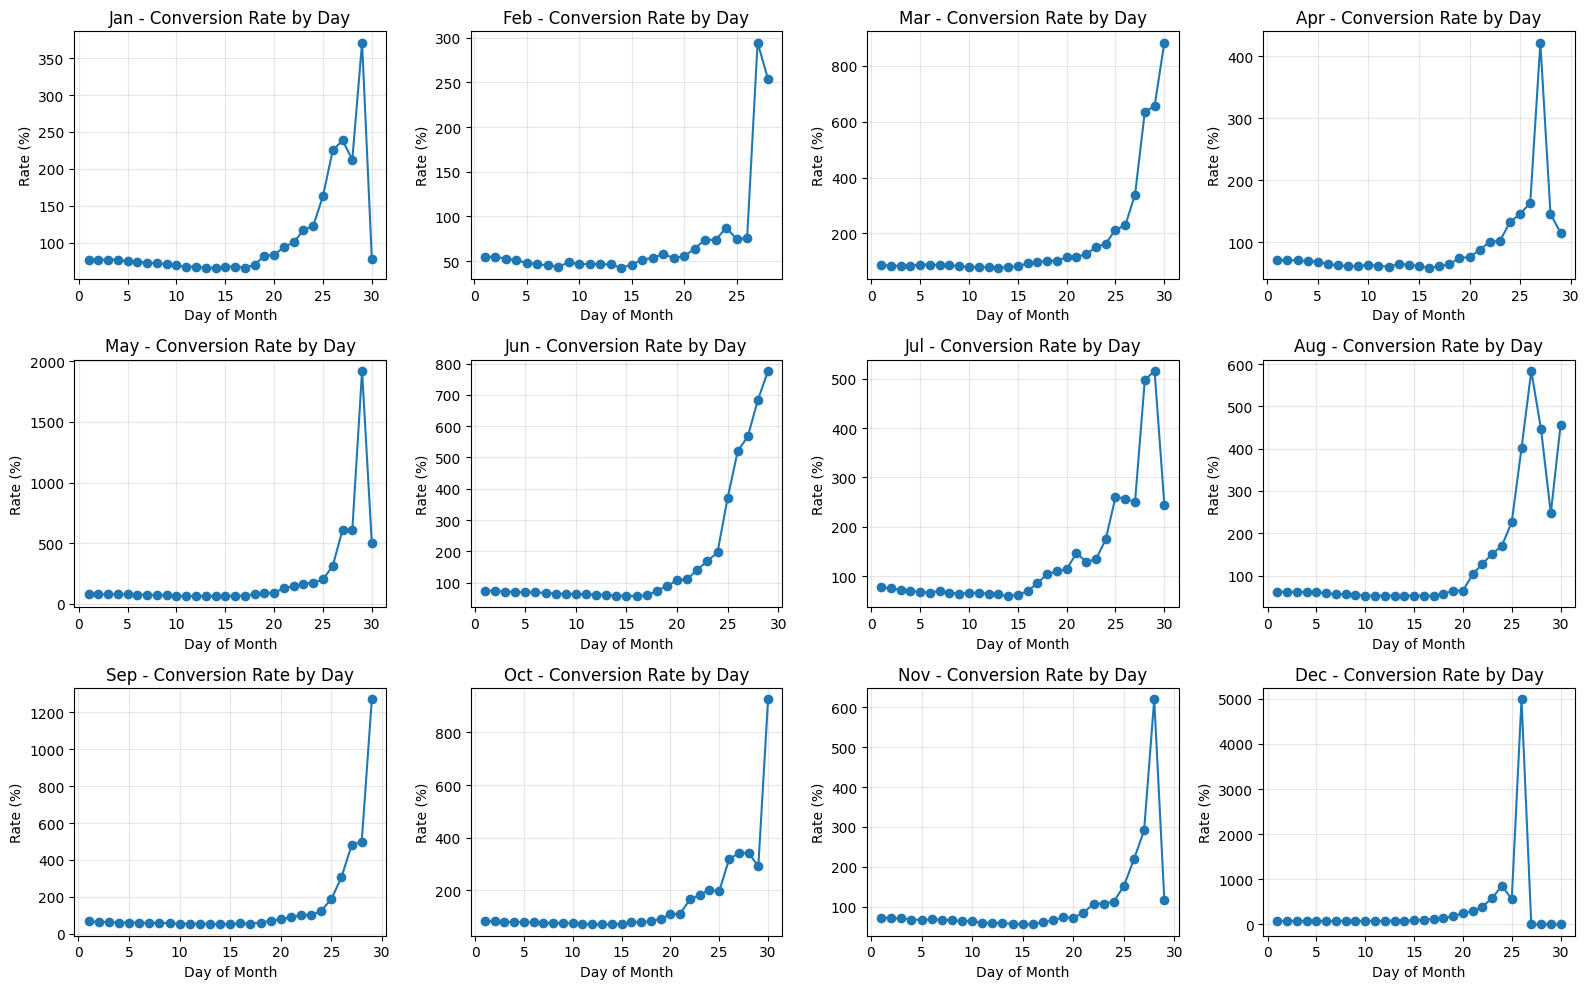

In [24]:
# 月内の日による転換率の変化を可視化
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for m in range(1, 13):
    month_data = train_data[train_data['month'] == m]
    if len(month_data) > 0:
        daily_avg = month_data.groupby('day')['Conversion_Rate'].mean()
        axes[m-1].plot(daily_avg.index, daily_avg.values, marker='o')
        axes[m-1].set_title(f'{month_names[m]} - Conversion Rate by Day')
        axes[m-1].set_xlabel('Day of Month')
        axes[m-1].set_ylabel('Rate (%)')
        axes[m-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. モデル構築

In [25]:
class CurrentMonthMPPredictor:
    def __init__(self):
        self.model = None
        self.monthly_rates = {}
        self.overall_avg_rate = None

    def train(self, data):
        # 月別平均転換率を計算
        for m in range(1, 13):
            sub = data[data['month'] == m]
            if len(sub) > 0:
                self.monthly_rates[m] = sub['Conversion_Rate'].mean()
        self.overall_avg_rate = data['Conversion_Rate'].mean()

        # Random Forestモデルの訓練
        # 特徴量: B、C、D、月、日
        X = data[['B', 'C', 'D', 'month', 'day']]
        y = data['Additional']

        self.model = RandomForestRegressor(
            n_estimators=100,
            max_depth=7,  # 深さを増やして日次データの複雑さに対応
            random_state=42
        )
        self.model.fit(X, y)

        # モデル評価
        pred_additional = self.model.predict(X)
        pred = data['Confirmed'] + pred_additional

        return {
            'mae': mean_absolute_error(data['Current_Month_End_MP'], pred),
            'r2': r2_score(data['Current_Month_End_MP'], pred)
        }

    def predict(self, kakutei, a, b, c, d, month, day):
        """日次の確定値、A、B、C、Dから当月末のMPを予測"""
        confirmed = kakutei + a
        bcd = b + c + d

        # Random Forestによる予測
        add_rf = self.model.predict([[b, c, d, month, day]])[0]

        # 月別転換率による予測
        rate = self.monthly_rates.get(month, self.overall_avg_rate) / 100
        add_rate = bcd * rate

        # ハイブリッド予測（RF 70% + 転換率 30%）
        additional = add_rf * 0.7 + add_rate * 0.3

        return {
            'month': month,
            'day': day,
            'confirmed': confirmed,
            'additional': additional,
            'forecast': confirmed + additional,
            'bcd': bcd,
            'rate': rate * 100
        }

print('CurrentMonthMPPredictor defined!')

CurrentMonthMPPredictor defined!


In [26]:
predictor = CurrentMonthMPPredictor()
metrics = predictor.train(train_data)

print('Model Trained!')
print(f'MAE: {metrics["mae"]/10000:,.0f} (10K JPY)')
print(f'R2:  {metrics["r2"]:.3f}')

Model Trained!
MAE: 134 (10K JPY)
R2:  0.980


## 6. 予測実行

In [27]:
def show_prediction(p):
    mn = ['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    print('='*50)
    print(f'{mn[p["month"]]} Day {p["day"]} -> Month-End Forecast')
    print('='*50)
    print(f'Confirmed:  {p["confirmed"]/10000:>10,.0f} (10K)')
    print(f'Additional: {p["additional"]/10000:>10,.0f} (10K)')
    print(f'FORECAST:   {p["forecast"]/10000:>10,.0f} (10K)')
    print(f'Conv Rate: {p["rate"]:.1f}%')
    print('='*50)

In [28]:
# 最新データで予測
latest = df[~df['is_month_end']].iloc[-1]
print(f'Latest: {latest["date"].strftime("%Y-%m-%d")}')

p = predictor.predict(
    latest['Kakutei'], latest['A'],
    latest['B'], latest['C'], latest['D'],
    month=int(latest['month']),
    day=int(latest['day'])
)
show_prediction(p)

# 実際の月末MPと比較
actual_month_end = latest['Current_Month_End_MP']
print(f'\nActual Month-End MP: {actual_month_end/10000:>10,.0f} (10K)')
print(f'Prediction Error: {abs(p["forecast"] - actual_month_end)/10000:>10,.0f} (10K)')

Latest: 2026-02-08
Feb Day 8 -> Month-End Forecast
Confirmed:       6,123 (10K)
Additional:        699 (10K)
FORECAST:        6,822 (10K)
Conv Rate: 64.8%

Actual Month-End MP:      6,160 (10K)
Prediction Error:        661 (10K)


In [34]:
# カスタム予測例
# 例: 2月15日時点のデータから2月末を予測
p = predictor.predict(
    kakutei=9971617,
    a=51629781,
    b=5163672,
    c=8885254,
    d=5989644,
    month=2,  # 2月
    day=9    # 15日
)
show_prediction(p)

Feb Day 9 -> Month-End Forecast
Confirmed:       6,160 (10K)
Additional:      1,048 (10K)
FORECAST:        7,208 (10K)
Conv Rate: 64.8%


## 7. 月内予測精度の推移

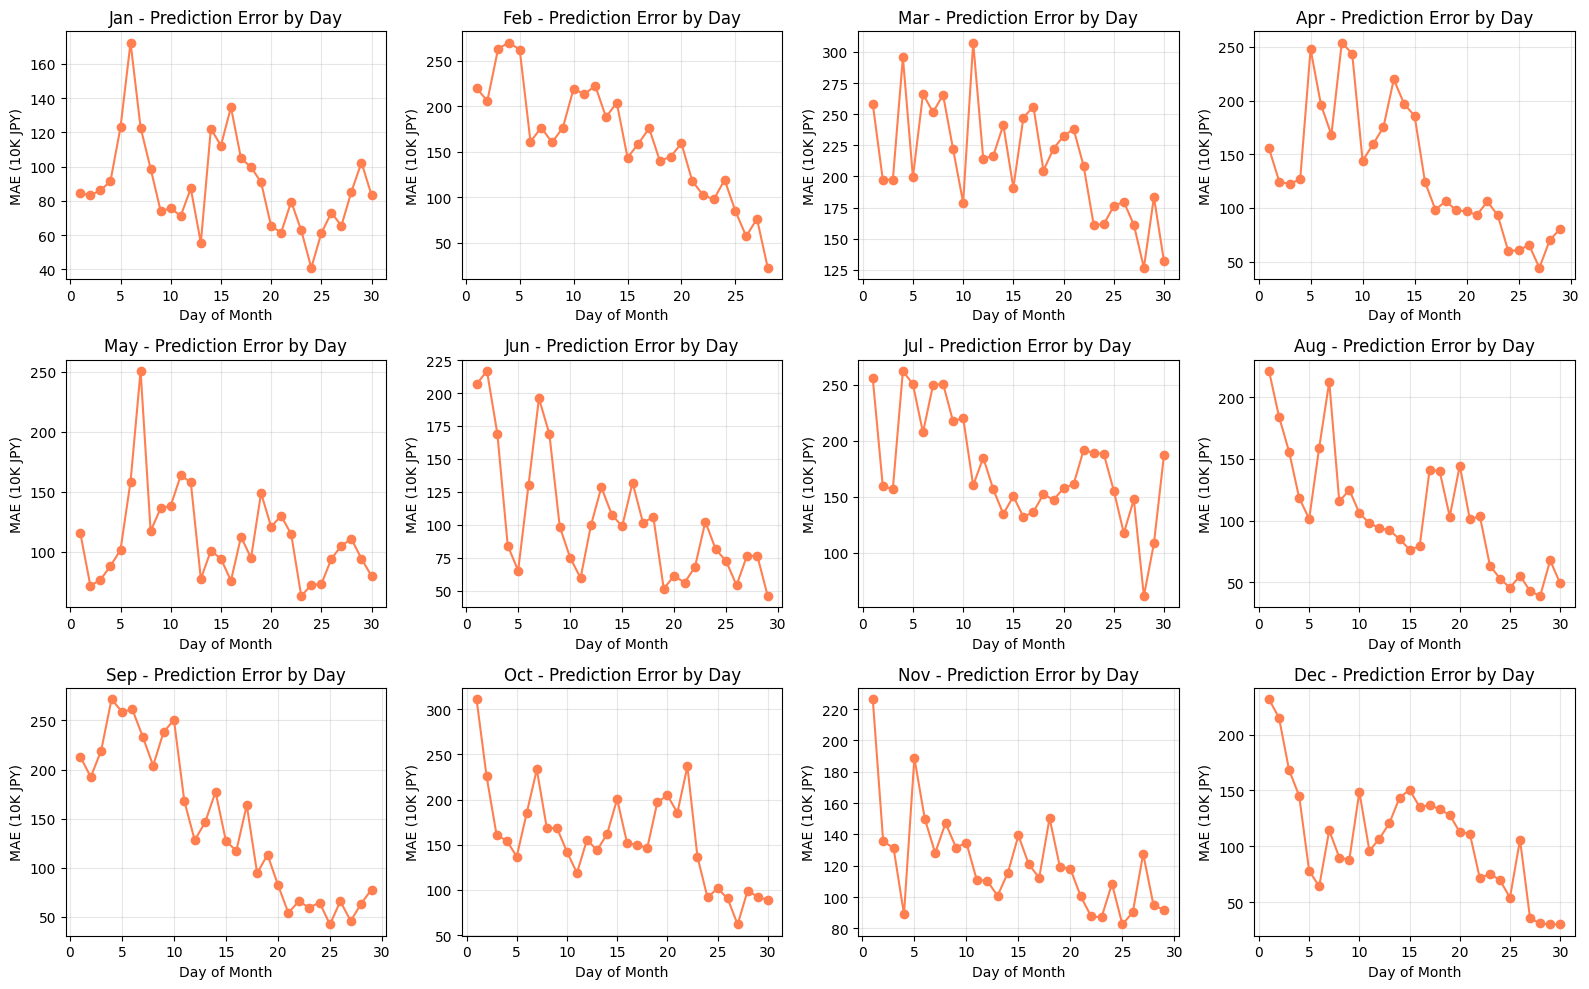

In [30]:
# 各月の日ごとの予測精度を分析
predictions_df = train_data.copy()
X_pred = predictions_df[['B', 'C', 'D', 'month', 'day']]
predictions_df['Predicted_Additional'] = predictor.model.predict(X_pred)
predictions_df['Predicted_Month_End_MP'] = predictions_df['Confirmed'] + predictions_df['Predicted_Additional']
predictions_df['Prediction_Error'] = abs(predictions_df['Predicted_Month_End_MP'] - predictions_df['Current_Month_End_MP'])

# 月別の予測誤差推移を可視化
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()
month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for m in range(1, 13):
    month_data = predictions_df[predictions_df['month'] == m]
    if len(month_data) > 0:
        daily_error = month_data.groupby('day')['Prediction_Error'].mean() / 10000
        axes[m-1].plot(daily_error.index, daily_error.values, marker='o', color='coral')
        axes[m-1].set_title(f'{month_names[m]} - Prediction Error by Day')
        axes[m-1].set_xlabel('Day of Month')
        axes[m-1].set_ylabel('MAE (10K JPY)')
        axes[m-1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 実績値と予測値の比較

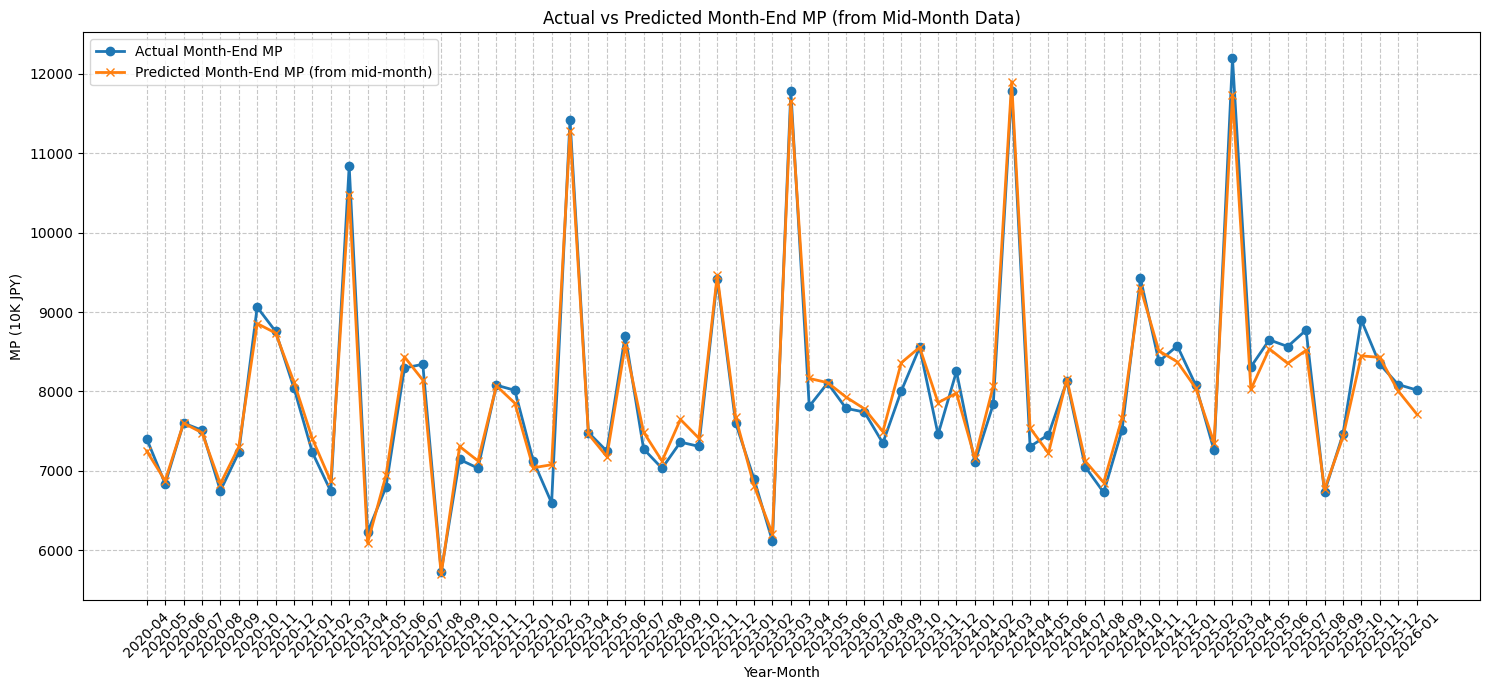


Mid-Month Prediction Statistics:
MAE: 147 (10K JPY)
Max Error: 481 (10K JPY)
Min Error: 0 (10K JPY)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# サンプルとして各月の中旬（15日前後）のデータを抽出して比較
mid_month_data = predictions_df[predictions_df['day'].between(14, 16)].copy()
mid_month_data = mid_month_data.groupby('year_month').first().reset_index()

plt.figure(figsize=(15, 7))
plt.plot(mid_month_data['year_month'].astype(str),
         mid_month_data['Current_Month_End_MP']/10000,
         label='Actual Month-End MP', marker='o', linewidth=2)
plt.plot(mid_month_data['year_month'].astype(str),
         mid_month_data['Predicted_Month_End_MP']/10000,
         label='Predicted Month-End MP (from mid-month)', marker='x', linewidth=2)

plt.title('Actual vs Predicted Month-End MP (from Mid-Month Data)')
plt.xlabel('Year-Month')
plt.ylabel('MP (10K JPY)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# 統計情報
print('\nMid-Month Prediction Statistics:')
print(f'MAE: {mid_month_data["Prediction_Error"].mean()/10000:,.0f} (10K JPY)')
print(f'Max Error: {mid_month_data["Prediction_Error"].max()/10000:,.0f} (10K JPY)')
print(f'Min Error: {mid_month_data["Prediction_Error"].min()/10000:,.0f} (10K JPY)')

## 9. 月内の日ごとのシミュレーション

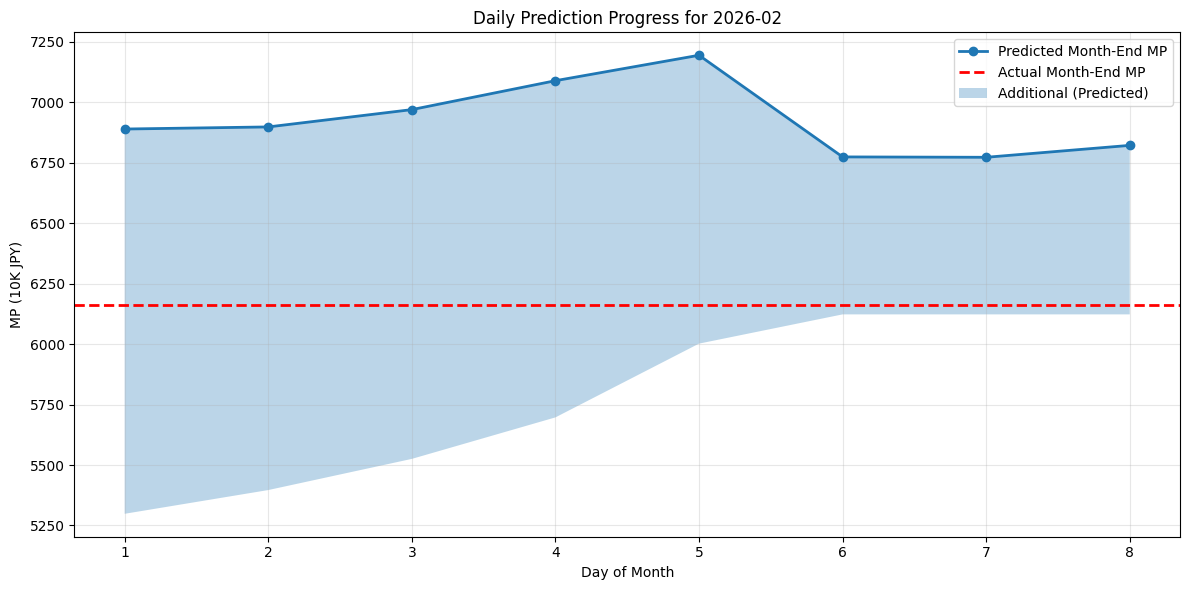


Daily Prediction Summary:


,day,confirmed,additional,forecast,actual
0,1,52982968,1.590903e+07,6.889200e+07,61601398
1,2,53964497,1.501441e+07,6.897891e+07,61601398
2,3,55253128,1.444158e+07,6.969470e+07,61601398
3,4,56968796,1.392180e+07,7.089059e+07,61601398
4,5,60018938,1.192343e+07,7.194237e+07,61601398
5,6,61227994,6.511326e+06,6.773932e+07,61601398
6,7,61227994,6.495568e+06,6.772356e+07,61601398
7,8,61227994,6.988257e+06,6.821625e+07,61601398


In [35]:
# 特定の月のデータを使って、日ごとの予測がどう変化するかシミュレーション
latest_month = df[df['year_month'] == df['year_month'].max()].copy()
latest_month = latest_month[~latest_month['is_month_end']]

if len(latest_month) > 0:
    simulation_results = []

    for _, row in latest_month.iterrows():
        p = predictor.predict(
            row['Kakutei'], row['A'],
            row['B'], row['C'], row['D'],
            month=int(row['month']),
            day=int(row['day'])
        )
        simulation_results.append({
            'date': row['date'],
            'day': row['day'],
            'confirmed': p['confirmed'],
            'additional': p['additional'],
            'forecast': p['forecast'],
            'actual': row['Current_Month_End_MP']
        })

    sim_df = pd.DataFrame(simulation_results)

    # 可視化
    plt.figure(figsize=(12, 6))
    plt.plot(sim_df['day'], sim_df['forecast']/10000,
             label='Predicted Month-End MP', marker='o', linewidth=2)
    plt.axhline(y=sim_df['actual'].iloc[0]/10000,
                color='red', linestyle='--', label='Actual Month-End MP', linewidth=2)
    plt.fill_between(sim_df['day'],
                     sim_df['confirmed']/10000,
                     sim_df['forecast']/10000,
                     alpha=0.3, label='Additional (Predicted)')

    plt.title(f'Daily Prediction Progress for {latest_month.iloc[0]["year_month"]}')
    plt.xlabel('Day of Month')
    plt.ylabel('MP (10K JPY)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('\nDaily Prediction Summary:')
    display(sim_df[['day', 'confirmed', 'additional', 'forecast', 'actual']].head(10))
else:
    print('No data available for simulation')


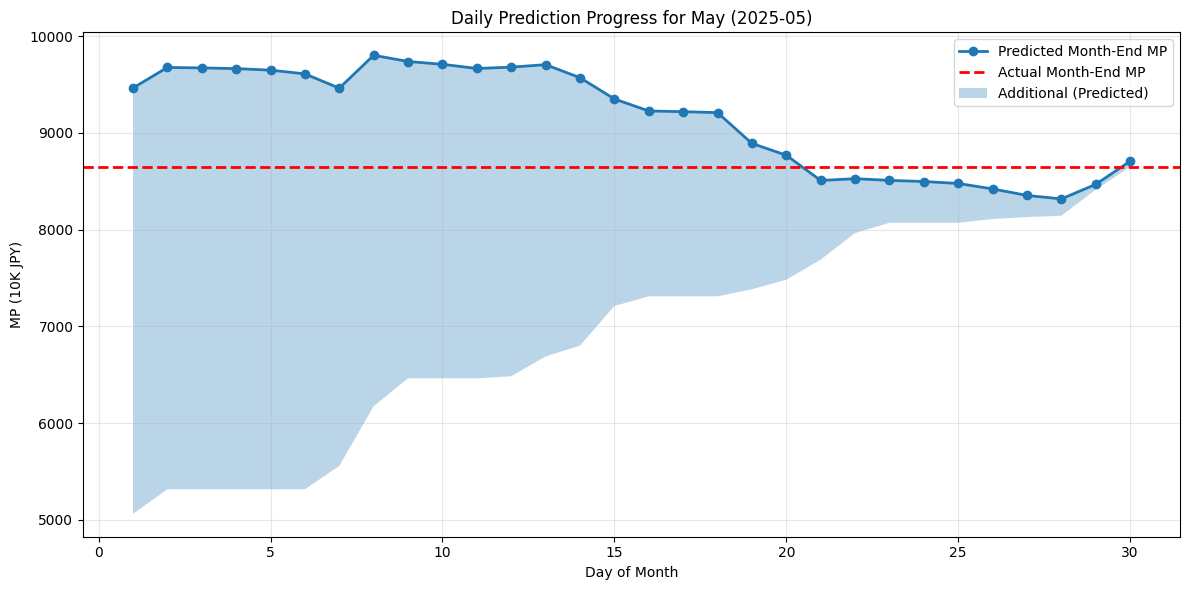


Daily Prediction Summary for May:


,day,confirmed,additional,forecast,actual
0,1,50615334,4.403036e+07,9.464569e+07,86495140
1,2,53150059,4.362215e+07,9.677221e+07,86495140
2,3,53150059,4.357210e+07,9.672216e+07,86495140
3,4,53150059,4.350119e+07,9.665125e+07,86495140
4,5,53150059,4.334076e+07,9.649082e+07,86495140
5,6,53150059,4.295475e+07,9.610481e+07,86495140
6,7,55569198,3.905668e+07,9.462588e+07,86495140
7,8,61740721,3.629027e+07,9.803099e+07,86495140
8,9,64623081,3.276120e+07,9.738429e+07,86495140
9,10,64623081,3.247260e+07,9.709569e+07,86495140


In [47]:
# ユーザーの要求により、指定の月で日ごとの予測シミュレーションを実行

# ターゲット月を指定 (1=1月, 2=2月, ..., 12=12月)
target_month = 5 #@param {type:"integer"}

# データから指定月のエントリーをすべて抽出
selected_month_data_all_years = df[df['month'] == target_month]

if not selected_month_data_all_years.empty:
    # 存在する指定月のデータの中で最新の年月を取得
    latest_selected_year_month = selected_month_data_all_years['year_month'].max()

    # 最新の指定月のデータのみを抽出
    latest_selected_month_data = df[df['year_month'] == latest_selected_year_month].copy()
    latest_selected_month_data = latest_selected_month_data[~latest_selected_month_data['is_month_end']]

    if len(latest_selected_month_data) > 0:
        simulation_results_selected_month = []

        for _, row in latest_selected_month_data.iterrows():
            p = predictor.predict(
                row['Kakutei'], row['A'],
                row['B'], row['C'], row['D'],
                month=int(row['month']),
                day=int(row['day'])
            )
            simulation_results_selected_month.append({
                'date': row['date'],
                'day': row['day'],
                'confirmed': p['confirmed'],
                'additional': p['additional'],
                'forecast': p['forecast'],
                'actual': row['Current_Month_End_MP']
            })

        sim_df_selected_month = pd.DataFrame(simulation_results_selected_month)

        # 月の名前を取得 (既に定義されている month_names を使用)
        month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_name = month_names[target_month] if 1 <= target_month <= 12 else str(target_month)

        # 可視化
        plt.figure(figsize=(12, 6))
        plt.plot(sim_df_selected_month['day'], sim_df_selected_month['forecast']/10000,
                 label='Predicted Month-End MP', marker='o', linewidth=2)
        plt.axhline(y=sim_df_selected_month['actual'].iloc[0]/10000,
                    color='red', linestyle='--', label='Actual Month-End MP', linewidth=2)
        plt.fill_between(sim_df_selected_month['day'],
                         sim_df_selected_month['confirmed']/10000,
                         sim_df_selected_month['forecast']/10000,
                         alpha=0.3, label='Additional (Predicted)')

        plt.title(f'Daily Prediction Progress for {month_name} ({latest_selected_month_data.iloc[0]["year_month"]})')
        plt.xlabel('Day of Month')
        plt.ylabel('MP (10K JPY)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f'\nDaily Prediction Summary for {month_name}:')
        display(sim_df_selected_month[['day', 'confirmed', 'additional', 'forecast', 'actual']])
    else:
        print(f'No daily data available for simulation in {latest_selected_year_month} for month {target_month}.')
else:
    print(f'データに月 {target_month} の情報がないため、シミュレーションを実行できません。')
